<a href="https://colab.research.google.com/github/ArcBytes0/Data-Science-Notebook/blob/main/Weed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'crop-and-weed-detection-data-with-bounding-boxes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F589173%2F1062313%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240817%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240817T140327Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D97026bdd5858cbbe9bd30b2381448bb60bf1f4f97acb6041a0826eb4c76db2ab8e2019e09541a8a484d396f2f45cde97da76df0cc24e539232a4770e7f10cc8f0c4a73183900e97889f9783a3521af61208b93b23f535c664b0b160d859af88113a03dde5b0b00329ac77329946e4d95c55c45c3f1c204521b27c5590e005a8d42029914b6355c73e66145bd20f237a7cf6e3ad95752de4e4bbaacd1b117fab132c64a8c79c1ba5f233ee5a02e9c16257b3ff7797479ac3219c62131df4e830793cda84c89f7904aeff15fad601a0fe56e9b8037e9e0aecf664838d5c65f8970a66b3ffaef8f472e42a1802072d6d5b98a654523cab8ec6137ed5d758781149c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 83008512 bytes downloaded
Downloaded and uncompressed: crop-and-weed-detection-data-with-bounding-boxes
Data source import complete.


# Load Data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:10]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/classes.txt
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_4994.jpeg
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_8797.txt
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_462.txt
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_8830.jpeg
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_784.jpeg
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_808.jpeg
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_6481.txt
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_5615.jpeg
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_8315.jpeg
/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/dat

In [3]:
main_dir = '/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/'

with open(main_dir+'classes.txt','r') as file:
    class_names = [line.strip() for line in file.readlines()]

class_names

['crop', 'weed']

In [4]:
data_dir = main_dir+'agri_data/data/'

In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
image_filenames = [os.path.splitext(filename)[0] for filename in os.listdir(data_dir) if filename.endswith('.jpeg')]
image_filenames[:10]

['agri_0_4994',
 'agri_0_8830',
 'agri_0_784',
 'agri_0_808',
 'agri_0_5615',
 'agri_0_8315',
 'agri_0_1024',
 'agri_0_5318',
 'agri_0_6879',
 'agri_0_7573']

In [7]:
for image_filename in image_filenames[:10]:
    # Read image
    image_path = os.path.join(data_dir, image_filename + '.txt')
    with open(os.path.join(data_dir, image_filename + '.txt'), 'r') as file:
        lines = file.readlines()
        print(lines)

['0 0.528320 0.548828 0.943359 0.546875\n', '0 0.355469 0.146484 0.523438 0.289062\n']
['1 0.389648 0.693359 0.697266 0.500000\n', '1 0.488281 0.230469 0.667969 0.320312\n']
['1 0.498047 0.461914 0.472656 0.607422\n']
['1 0.450195 0.566406 0.701172 0.621094\n']
['1 0.414062 0.493164 0.480469 0.705078\n']
['0 0.504883 0.526367 0.990234 0.888672\n']
['1 0.601562 0.448242 0.570312 0.595703\n']
['1 0.421875 0.435547 0.734375 0.453125\n']
['0 0.505859 0.494141 0.921875 0.820312\n']
['0 0.487305 0.536133 0.810547 0.626953\n']


# Visualise

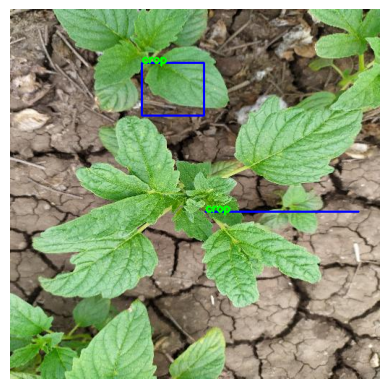

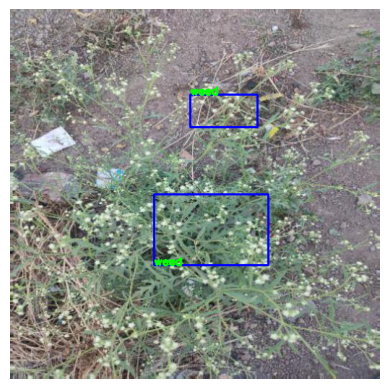

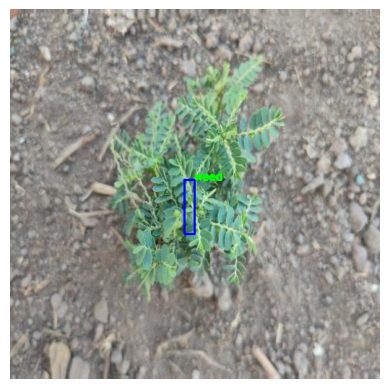

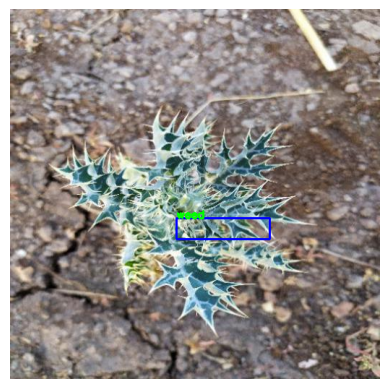

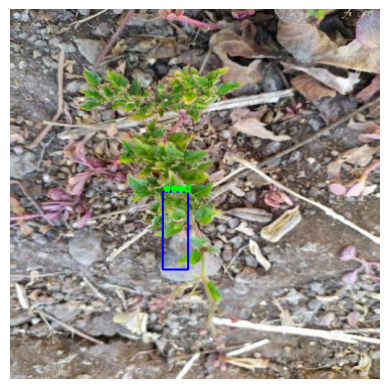

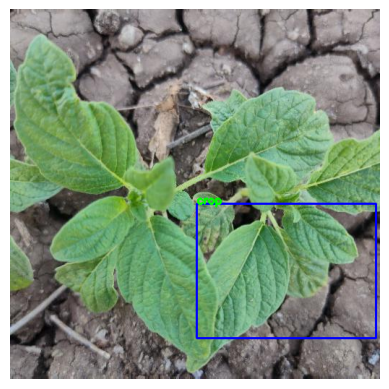

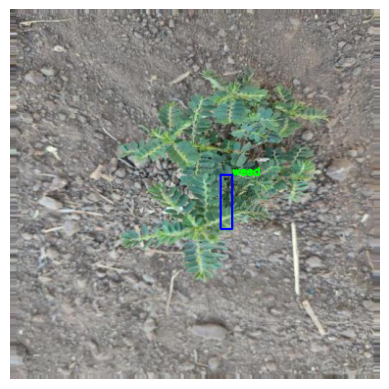

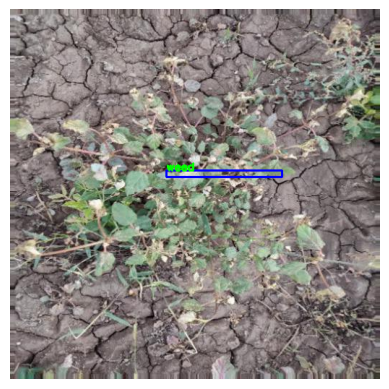

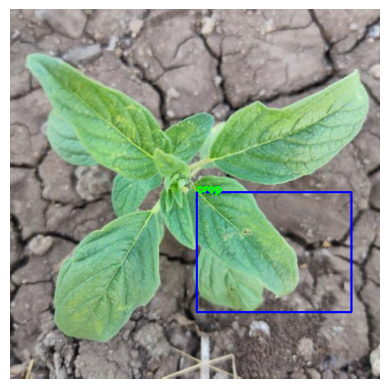

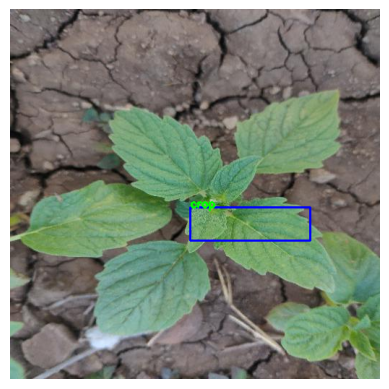

In [8]:
for image_filename in image_filenames[:10]:
    # Read image
    image_path = os.path.join(data_dir, image_filename + '.jpeg')
    image = cv2.imread(image_path)

    with open(os.path.join(data_dir, image_filename + '.txt'), 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = line.strip().split()
            class_index = int(data[0])
            x_min = int(float(data[1]) * image.shape[1])
            y_min = int(float(data[2]) * image.shape[0])
            x_max = int(float(data[3]) * image.shape[1])
            y_max = int(float(data[4]) * image.shape[0])
            # Draw bounding box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            # Add class label
            class_label = class_names[class_index]  # Assuming class_names is defined
            cv2.putText(image, class_label, (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display image with bounding boxes and class labels
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### Data is evenly distributed

In [ ]:
import numpy as np

# Load images and corresponding labels
X = []
y_bbox = []  # Bounding box labels
y_class = []  # Classification labels

for filename in os.listdir(data_dir):
    if filename.endswith('.jpeg'):
        # Load image
        image_path = os.path.join(data_dir, filename)
        image = cv2.imread(image_path)
        # Add image to X
        X.append(image)

        # Load corresponding label
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(data_dir, label_filename)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            # Only consider 1 BBOX
            for line in lines[:1]:
                data = line.strip().split()
                class_index = int(data[0])
                x_min = float(data[1])
                y_min = float(data[2])
                x_max = float(data[3])
                y_max = float(data[4])
                # Calculate bounding box coordinates relative to image dimensions
                bbox = [x_min, y_min, x_max, y_max]
                # Add bounding box label to y_bbox
                y_bbox.append(bbox)
                # Add classification label to y_class
                # Assuming class labels are already one-hot encoded
                # You might need to adjust this part based on your label format
                class_label = class_index
                y_class.append(class_label)

X = np.array(X)
y_bbox = np.array(y_bbox)
y_class = np.array(y_class)

# Print shapes to verify
print("X shape:", X.shape)
print("Bounding box labels shape:", y_bbox.shape)
print("Classification labels shape:", y_class.shape)


In [ ]:
from collections import Counter

# Assuming y_classes is a list/array containing class labels
class_counts = Counter(y_class)

# Total number of classes
total_classes = len(class_counts)

# Print total number of classes
print("Total number of classes:", total_classes)

# Print population in each class
print("Population in each class:")
for class_label, count in class_counts.items():
    print("Class:", class_label, "| Count:", count)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_bbox_train, y_bbox_test, y_class_train, y_class_test = train_test_split(X, y_bbox, y_class, test_size=0.2, random_state=42,shuffle=True)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_bbox_train shape:", y_bbox_train.shape)
print("y_bbox_test shape:", y_bbox_test.shape)
print("y_class_train shape:", y_class_train.shape)
print("y_class_test shape:", y_class_test.shape)

# Classification Model Only

In [ ]:
input_shape = (None, None, 3)
target_size = (224, 224)
num_classes = 2

# Build a CNN model
model_1=tf.keras.models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(target_size[0], target_size[1]),
    layers.Rescaling(scale=1./255),
    layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# Compile CNN
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(model_1, to_file='classification_model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
history_1 = model_1.fit(
    X_train,y_class_train,
    batch_size=32,
    validation_data=(X_test,y_class_test),
    epochs=10
)

## Classification Results

We achieved 93.96% accuracy for weed and crop binary classification

# Classification and Detection
I dont expect this to work as the bbox labels were not very accurate

## Create Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

input_shape = (None, None, 3)
target_size = (224, 224)
num_classes = 2

inputs = layers.Input(shape=input_shape)
resized_inputs = layers.Resizing(target_size[0], target_size[1])(inputs)
rescaled_inputs = layers.Rescaling(scale=1./255)(resized_inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(rescaled_inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Bounding box regression branch
bbox_output = layers.Dense(64, activation='relu')(x)
bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(bbox_output)

# Binary classification branch
classification_output = layers.Dense(64, activation='relu')(x)
classification_output = layers.Dense(1, activation='sigmoid', name='classification_output')(classification_output)  # Output: softmax for binary classification

# Create model
model = Model(inputs=inputs, outputs=[bbox_output, classification_output])

model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='detection_and_classification_model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Define loss functions
bbox_loss_fn = tf.keras.losses.MeanSquaredError()
class_loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define metrics
metrics = ['accuracy']

model.compile(optimizer='adam',
              loss={'bbox_output': bbox_loss_fn, 'classification_output': class_loss_fn},
              metrics={'bbox_output': metrics, 'classification_output': metrics})

history = model.fit(X_train, {'bbox_output': y_bbox_train, 'classification_output': y_class_train},
                    validation_data=(X_test, {'bbox_output': y_bbox_test, 'classification_output': y_class_test}),
                    batch_size=32,
                    epochs=10)

## Detection And Classification Result
A simpler model was used for classificatin to make the model less complex.
The classification result are almost the same as the previous model but detection can be improved. Moreover as the data is not consistently annotated the model results are not expected to improve much.
* 90.77% accuracy in classification
* 56.15% accuracy in detection

### Future Goals
* Using Transfer Learning
* Better Annotation of the data